<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/post_training_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [7]:
cd '/gdrive/My Drive/abv_reviews'

/gdrive/My Drive/abv_reviews


In [1]:
!pip install -U spacy[cuda100]

     |████████████████████████████████| 10.4MB 4.8MB/s 
     |████████████████████████████████| 3.7MB 48.4MB/s 
     |████████████████████████████████| 122kB 55.8MB/s 
     |████████████████████████████████| 2.2MB 39.7MB/s 
     |████████████████████████████████| 382.9MB 38kB/s 
  Found existing installation: blis 0.2.4
    Uninstalling blis-0.2.4:
      Successfully uninstalled blis-0.2.4
  Found existing installation: preshed 2.0.1
    Uninstalling preshed-2.0.1:
      Successfully uninstalled preshed-2.0.1
  Found existing installation: thinc 7.0.8
    Uninstalling thinc-7.0.8:
      Successfully uninstalled thinc-7.0.8
  Found existing installation: spacy 2.1.9
    Uninstalling spacy-2.1.9:
      Successfully uninstalled spacy-2.1.9


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import random
import srsly
import json
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy import displacy
from spacy.util import minibatch, compounding
from pandas.io.json import json_normalize
from spacy.gold import docs_to_json, biluo_tags_from_offsets, offsets_from_biluo_tags
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

from spacy.util import decaying


⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [3]:
spacy.prefer_gpu()

True

In [0]:
def cleanse_text(text):
  step1 = re.sub(r"(\{'LOWER':\s)",r"",str(text))
  step2 = re.sub(r"[\[{\'\,\"}\]]",r"",step1)
  return step2

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']

        print(text, annotations)
        valid_entities = []
        for start, end, label in entities:
          valid_start = start
          valid_end = end
          print(valid_start, valid_end, len(text))
          while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
            valid_start += 1
          while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
            valid_end -= 1
          valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])

    return cleaned_data

def dump_jsonl(data, output_path, append=False):
    """
    Write list of objects to a JSON lines file.
    """
    mode = 'a+' if append else 'w'
    with open(output_path, mode, encoding='utf-8') as f:
        for line in data:
            json_record = json.dumps(line, ensure_ascii=False)
            f.write(json_record + '\n')
    print('Wrote {} records to {}'.format(len(data), output_path))

def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data


def create_entity_pattern(ent_name, ent_label):
  pattern_list = []
  pattern_dict = {}
  id_str = ''
  for word in ent_name.lower().split():
    token_dict = {}
    token_dict['LOWER'] = word
    pattern_list.append(token_dict)
    id_str += '_' + word
  if ent_label[:2] == 'U_':
    pattern_dict['label'] = ent_label[2:]
  else:
    pattern_dict['label'] = ent_label  
  pattern_dict['pattern'] = pattern_list
  if id_str[0] == '_':
    id_str = id_str[1:]
  pattern_dict['id'] = id_str
  return pattern_dict

In [8]:
train_data = load_jsonl('train.jsonl')
type(train_data)

Loaded 1000 records from train.jsonl


list

In [12]:
type(en_core_web_lg)

module

In [0]:
nlp = en_core_web_lg.load()

In [13]:
model = 'en_core_web_lg'
#model = None


"""Load the model, set up the pipeline and train the entity recognizer."""
if model is not None:
    nlp = en_core_web_lg.load()  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

# add labels
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Loaded model 'en_core_web_lg'


In [14]:
ner.labels

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART',
 'beverage',
 'bread',
 'condiment',
 'dish',
 'food_habit',
 'fruit',
 'herb',
 'lifestyle',
 'meal',
 'pastry',
 'product',
 'sandwich',
 'seed',
 'spice',
 'vegetable',
 'vegetableU_spice')

In [0]:
dropout = decaying(0.6, 0.2, 1e-4)

In [17]:
next(dropout)

0.5999

In [0]:
# get names of other pipes to disable them during training
#other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner", "entity_ruler","merge_entities"]]

other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner"]]

loss_trend = []
with nlp.disable_pipes(*other_pipes):  # only train NER
    # reset and initialize the weights randomly – but only if we're
    # training a new model
    if model is None:
        nlp.begin_training()



    for itn in range(200):
      random.shuffle(train_data)
      losses = {}

#      for item in clean_train_ents:
# batch up the examples using spaCy's minibatch
      batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))

      for batch in batches:
        texts, annotations = zip(*batch)
#        print([item[0]], [item[1]])

#        print(texts)
#        print(annotations)
        nlp.update(texts, annotations, drop=next(dropout), losses=losses)
        loss_trend.append(losses['ner'])

In [0]:
import seaborn as sns

In [25]:
loss_trend

[245.08283400535583,
 669.137021780014,
 973.1348836421967,
 1250.6717293262482,
 1656.3692877292633,
 1908.5378210544586,
 2146.511801481247,
 2365.4678637981415,
 2804.4378554821014,
 3135.4046333823353,
 3399.201971868053,
 3550.1626661811024,
 3956.898047307506,
 4160.105110505596,
 4368.195422748104,
 4615.21020946838,
 5055.9108987841755,
 5268.423066237941,
 5428.897396663204,
 5735.454948047176,
 5951.424540141597,
 6078.1497646365315,
 6357.259116748348,
 6581.9380336795,
 6742.56984958984,
 6904.0658889804035,
 7506.4580570254475,
 7786.162561992183,
 7999.2948504481465,
 8220.025570729747,
 8465.900627950206,
 8768.009950498119,
 8961.69323025085,
 9159.567160228267,
 9330.985387424007,
 9473.617841819301,
 9600.802021602169,
 9978.085938075557,
 10161.154475787655,
 10321.328083613887,
 10531.388797381893,
 10804.056508639827,
 10955.092108348384,
 11210.405599216,
 11343.00905428268,
 11564.669119456783,
 11711.616958716884,
 11911.677811244503,
 12085.481815913692,
 12422

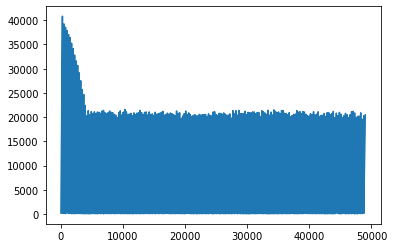

In [29]:
plt.plot(loss_trend)

In [30]:
df_pattern = pd.read_json('patterns.jsonl',lines=True)
df_pattern['cleaned_pattern'] = df_pattern.pattern.apply(lambda x: cleanse_text(x))
df_pattern['label'] = 'U_' + df_pattern.label.astype(str)
df_pattern['tup_col'] = list(zip(df_pattern.cleaned_pattern, df_pattern.label))
df_pattern['merged'] = df_pattern.apply(lambda row: {row['cleaned_pattern']:row['label']}, axis=1)
df_pattern.head()
df_pattern.tail()

,label,pattern,id,cleaned_pattern,tup_col,merged
7682,U_vegetable,"[{'LOWER': 'wing'}, {'LOWER': 'bean'}]",wing_bean,wing bean,"(wing bean, U_vegetable)",{'wing bean': 'U_vegetable'}
7683,U_vegetable,"[{'LOWER': 'yellow'}, {'LOWER': 'pepper'}]",yellow_pepper,yellow pepper,"(yellow pepper, U_vegetable)",{'yellow pepper': 'U_vegetable'}
7684,U_vegetable,"[{'LOWER': 'yellow'}, {'LOWER': 'zucchini'}]",yellow_zucchini,yellow zucchini,"(yellow zucchini, U_vegetable)",{'yellow zucchini': 'U_vegetable'}
7685,U_vegetable,[{'LOWER': 'zucchini'}],zucchini,zucchini,"(zucchini, U_vegetable)",{'zucchini': 'U_vegetable'}
7686,U_vegetable,[{'LOWER': 'zucchinis'}],zucchinis,zucchinis,"(zucchinis, U_vegetable)",{'zucchinis': 'U_vegetable'}


In [31]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [34]:
reviews = pd.read_csv('reviews_text.csv',usecols=['_id', 'text','overall','originality','value','nutrition','presentation','taste','dish','type','user','restaurant'])
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56156 entries, 0 to 56155
Data columns (total 12 columns):
_id             56156 non-null object
originality     56156 non-null int64
value           56156 non-null int64
nutrition       56156 non-null int64
presentation    56156 non-null int64
taste           56156 non-null int64
text            56155 non-null object
dish            56156 non-null object
type            56156 non-null object
user            56156 non-null object
restaurant      56156 non-null object
overall         56156 non-null float64
dtypes: float64(1), int64(5), object(6)
memory usage: 5.1+ MB


In [19]:
reviews.dropna(inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56155 entries, 0 to 56155
Data columns (total 12 columns):
_id             56155 non-null object
originality     56155 non-null int64
value           56155 non-null int64
nutrition       56155 non-null int64
presentation    56155 non-null int64
taste           56155 non-null int64
text            56155 non-null object
dish            56155 non-null object
type            56155 non-null object
user            56155 non-null object
restaurant      56155 non-null object
overall         56155 non-null float64
dtypes: float64(1), int64(5), object(6)
memory usage: 5.6+ MB


In [20]:
reviews['user'].nunique()

5714

In [25]:
reviews['dish'].nunique()

43668

In [26]:
reviews['restaurant'].nunique()

16881

In [27]:
reviews.groupby(['user','restaurant','dish'],as_index=False)['text'].count().sort_values(by=['text'],ascending=False)

,user,restaurant,dish,text
544,59c489e73e616a0004f9bcf7,5a08f8326d62fc000456e328,5c4feb845de4510004556ddd,16
10658,5acb8f9dd5fbb40004e7a793,5c4c28a0db404600045f3372,5c4c28dddb404600045f3373,12
42319,5d3f28ffd45aa9000435db9b,5d6628871b64cf00048d6090,5d668ae51b64cf00048d6f27,10
573,59c489e73e616a0004f9bcf7,5a277fb0adeb5c0004e599d8,5a2781f1adeb5c0004e599df,9
488,59c489e73e616a0004f9bcf7,59f2d53bdc652e000489b37e,59f2d943dc652e000489b38a,9
...,...,...,...,...
18495,5bb52c0d1c6cca00048806b3,5ad0618f02994d00048ff42b,5ad061fb02994d00048ff42d,1
18496,5bb52c0d1c6cca00048806b3,5b99db50c3087d000410adbe,5bb52eba1c6cca00048806bf,1
18497,5bb52c0d1c6cca00048806b3,5bb52f8a1c6cca00048806ca,5bb530661c6cca00048806d2,1
18498,5bb5c5c21c6cca000488084b,5ab99bfe158f6d0004fcfba0,5bb5cfe81c6cca0004880858,1


In [29]:
reviews.groupby(['restaurant','user'],as_index=False)['text'].count().sort_values(by=['text'],ascending=False)

,restaurant,user,text
461,59c20f081747f4000483765d,5adaeab7b433a40004dc0259,102
16453,5c028cda3434a90004fde9a9,5d1b99f20d225d000450df53,85
539,59c20f081747f4000483765d,5c95cdd9d893940004247c9e,56
26789,5d28047889291800043a487f,5cfbf6e0a95ce3000492d4c0,55
30169,5dad6aa63b499c00209f8569,5da9242a90ae8b0020fac517,52
...,...,...,...
12786,5b672fea2fd1a7000431f14a,5cdcde41faa8b9000444c4e5,1
12784,5b672fea2fd1a7000431f14a,5bf2ba16f21e730004d3307b,1
12782,5b672fea2fd1a7000431f14a,5b3f1d52f46f500004ae0d6c,1
12781,5b672fea2fd1a7000431f14a,5ac7bf61dde05700046de152,1


In [34]:
reviews.query('user == "59c489e73e616a0004f9bcf7" & dish == "5c4feb845de4510004556ddd"')['text'][16485]


'Startup life and vegan junk food is starting to show on me and so I’ve been on a health kick and nothing could be better than my custom wrap at SaladStop. I get #sustenir kale which is hydroponic kale grown here in Singapore 🇸🇬 and a whole bunch of fresh veggies. If I could just eat like this all the time!\n\n#greeeeen #wraps #saladstop'

In [0]:
train_reviews = reviews[:1000]
eval_reviews = reviews[1000:2000]
test_reviews = reviews[2000:3000]

In [36]:
eval_docs = eval_reviews['text'][:20]

for doc in eval_docs:
  displacy.render(nlp(doc),'ent',jupyter=True)
  print([(ent.text, ent.label_) for ent in nlp(doc).ents])

[('sauce', 'condiment')]


[('asparagus', 'vegetable'), ('mushroom', 'vegetable')]


[('salad', 'dish'), ('tofu', 'dish'), ('pomelo', 'fruit'), ('corn', 'vegetable'), ('carrots', 'vegetable'), ('quinoa', 'dish'), ('salad', 'dish'), ('salad', 'dish'), ('vegan', 'lifestyle'), ('vegetarian', 'lifestyle')]


[('vegetarians', 'food_habit'), ('veg set', 'food_habit'), ('sour soup', 'condiment'), ('fried rice', 'dish'), ('veggies', 'vegetable'), ('tofu', 'dish'), ('egg', 'dish'), ('dinner', 'meal'), ('soup', 'dish')]


[]


[('linguine', 'dish'), ('cashew nut cream cheese', 'dish'), ('spinach', 'vegetable'), ('spinach', 'vegetable'), ('20mins', 'ORDINAL'), ('pasta', 'dish'), ('pasta', 'dish'), ('mins', 'TIME')]


[('pasta', 'dish'), ('vegan', 'lifestyle'), ('pasta', 'dish')]


[('spinach', 'vegetable'), ('pasta', 'dish')]


[('7', 'CARDINAL'), ('snack', 'meal'), ('sweet sauce', 'condiment')]


[('donut', 'dish'), ('banana cream', 'condiment'), ('banana', 'fruit'), ('chocolate', 'dish'), ('donut', 'dish'), ('days', 'DATE'), ('donuts', 'pastry')]


[('Cheese', 'dish'), ('bread', 'bread'), ('vegan', 'lifestyle'), ('cheese', 'dish'), ('cheeseries', 'ORG'), ('first', 'ORDINAL'), ('vegan', 'lifestyle'), ('cheese', 'dish'), ('night', 'TIME'), ('lunch', 'meal'), ('sandwich', 'dish'), ('vegan', 'lifestyle'), ('sandwich', 'dish'), ('Vegan cheese', 'dish'), ('avocado', 'fruit'), ('tomatoes', 'fruit'), ('kale', 'vegetable'), ('balsamic drizzle', 'condiment'), ('bread', 'bread'), ('vegan', 'lifestyle'), ('butter', 'condiment')]


[('bread', 'bread'), ('pumpkin', 'vegetable'), ('vegan cheese', 'dish'), ('veggies', 'vegetable'), ('winter melon', 'fruit'), ('mushroom', 'vegetable'), ('rice', 'dish'), ('tofu', 'dish'), ('kimchi', 'dish'), ('vegan', 'lifestyle')]


[('bacon', 'dish')]


[('dim sum', 'dish'), ('dumpling', 'dish'), ('vegan', 'lifestyle'), ('dumplings', 'dish'), ('truffle', 'vegetable')]


[('kale', 'vegetable'), ('goji berries', 'fruit')]


[('eggplant', 'vegetable')]


[('vegan', 'lifestyle'), ('egg', 'dish'), ('noodles', 'dish'), ('truffle', 'vegetable'), ('mushrooms', 'vegetable'), ('edamame', 'vegetable')]


[('tofu', 'dish'), ('silken tofu', 'dish'), ('enoki mushrooms', 'vegetable')]


[('kale', 'vegetable'), ('pomegranate seeds', 'seed'), ('veggie', 'vegetable')]


[('dessert', 'meal'), ('sweet soup', 'dish'), ('goji berries', 'fruit')]


In [38]:
!pip install spacymoji
from spacymoji import Emoji

     |████████████████████████████████| 51kB 4.3MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=9c8b1eeee3f5d24e79466a88628ed2c17646aa8dac817915bbd4a4a452de6080
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [39]:
emoji = Emoji(nlp)
nlp.add_pipe(emoji, first=True)
nlp.pipe_names

['emoji', 'tagger', 'parser', 'ner']

In [53]:
from spacy.pipeline import Tagger



spacy.pipeline.pipes.Tagger

In [40]:
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')
nlp.pipe_names

['emoji', 'tagger', 'parser', 'ner', 'merge_entities']

In [76]:
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")
nlp.add_pipe(ruler, before='ner')
nlp.pipe_names

['emoji', 'tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [0]:
nlp.to_disk('trained_model_2020_01_13')

In [41]:
nlp(eval_docs[1010])

Cheese meats bread offers a solid vegan grilled cheese option. Grilled cheeseries are hard to come across in the first place and to find a vegan option was pretty exciting. It tasted great, provided the comfort of a non-vegan grilled cheese, and it actually walked the line of late-night and healthy lunch food. I would definitely recommend it. My only wish is that they offer some of their other sandwich toppings with the vegan sandwich (you can't ask for substitutions).

Ingredients: Vegan cheese, smashed avocado, roasted tomatoes, kale, balsamic drizzle, whole wheat bread, vegan butter

In [0]:
from collections import Counter
def remove_duplicate_list_items(input_list):
  c = Counter(input_list)
  output_list = []
  for key in c.keys():
    if len(key) != 0:
      output_list.append(key)
  
  return output_list

In [60]:
l = ['carrots',
  'corn',
  'pomelo',
  'quinoa',
  'salad',
  'salad',
  'salad',
  'tofu',
  'vegan',
  'vegetarian']
Counter(l)

Counter({'carrots': 1,
         'corn': 1,
         'pomelo': 1,
         'quinoa': 1,
         'salad': 3,
         'tofu': 1,
         'vegan': 1,
         'vegetarian': 1})

In [156]:
ent_list = []
for doc in eval_reviews['text']:
#  displacy.render(nlp(doc),'ent',jupyter=True)
  ent_list.append([k  for k in Counter(sorted([(ent.ent_id_) for ent in nlp(doc).ents if ent.ent_id_ != ''])).keys()])
#ent_list.append([ent.text for ent in nlp(doc).ents if ent.ent_id_ == ''])

ent_list[-5:]

[['buns',
  'char_siu',
  'dipping_sauce',
  'hong_kong',
  'lunch',
  'mock_meats',
  'vegan'],
 ['chinese', 'curry', 'english', 'lunch', 'rice', 'sauce', 'vegan'],
 ['a_ton',
  'asparagus',
  'bread',
  'egg',
  'feta',
  'omelette',
  'tomato',
  'vegan',
  'vegetarian'],
 ['pepper', 'stuffed_tomatoes', 'vegan'],
 ['chocolate', 'dessert', 'hazelnuts']]

In [0]:
df_entities = pd.DataFrame(pd.Series(ent_list),columns=['entities'])

In [159]:
df_entities.tail()

,entities
995,"[buns, char_siu, dipping_sauce, hong_kong, lun..."
996,"[chinese, curry, english, lunch, rice, sauce, ..."
997,"[a_ton, asparagus, bread, egg, feta, omelette,..."
998,"[pepper, stuffed_tomatoes, vegan]"
999,"[chocolate, dessert, hazelnuts]"


In [160]:
eval_reviews.head()

,_id,originality,value,nutrition,presentation,taste,text,dish,type,user,restaurant,overall
1000,5a5e06be72aeaa00048cc4c8,4,3,4,4,4,The way the dish was presented was so differen...,5a5e06bc72aeaa00048cc4c7,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.8
1001,5a5e078772aeaa00048cc4cc,2,3,4,3,4,Off the menu and they added asparagus and mush...,5a5e078572aeaa00048cc4cb,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.2
1002,5a5eb04672aeaa00048cc505,5,4,5,4,5,Overall good salad that was healthy and hadn’t...,5a5eb04472aeaa00048cc504,dish,59d98c55ded2bc0004210661,5a08f8336d62fc000456e32f,4.6
1003,5a5f4c94935a8a0004fc9e75,2,3,3,3,3,Not much choices for vegetarians but they do h...,5a5f4c4e935a8a0004fc9e6f,dish,5a1a2eb0ee33f1000472ace3,59faa363f85af800044811a5,2.8
1004,5a602755935a8a0004fc9e89,5,5,5,5,4,So colorful. So much variety. I especially lik...,5a602753935a8a0004fc9e88,dish,59ec22d177466d00048bb2e2,5a0883fc6d62fc000456e323,4.8


In [165]:
eval_reviews.reset_index(drop=True)

,_id,originality,value,nutrition,presentation,taste,text,dish,type,user,restaurant,overall
0,5a5e06be72aeaa00048cc4c8,4,3,4,4,4,The way the dish was presented was so differen...,5a5e06bc72aeaa00048cc4c7,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.8
1,5a5e078772aeaa00048cc4cc,2,3,4,3,4,Off the menu and they added asparagus and mush...,5a5e078572aeaa00048cc4cb,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.2
2,5a5eb04672aeaa00048cc505,5,4,5,4,5,Overall good salad that was healthy and hadn’t...,5a5eb04472aeaa00048cc504,dish,59d98c55ded2bc0004210661,5a08f8336d62fc000456e32f,4.6
3,5a5f4c94935a8a0004fc9e75,2,3,3,3,3,Not much choices for vegetarians but they do h...,5a5f4c4e935a8a0004fc9e6f,dish,5a1a2eb0ee33f1000472ace3,59faa363f85af800044811a5,2.8
4,5a602755935a8a0004fc9e89,5,5,5,5,4,So colorful. So much variety. I especially lik...,5a602753935a8a0004fc9e88,dish,59ec22d177466d00048bb2e2,5a0883fc6d62fc000456e323,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...
995,5aa4beb014f5ac000443145c,5,5,5,5,4,Part of an all-you-can-eat vegan lunch set. Al...,5aa4beaf14f5ac000443145b,dish,5a4f34be991bc70004e1e3a9,5a9d4e51b31e0f00048f5382,4.8
996,5aa4bf9e14f5ac000443145f,3,2,3,3,3,Part of an all-you-can-eat vegan lunch set. Th...,5aa4bf9c14f5ac000443145e,dish,5a4f34be991bc70004e1e3a9,5a9d4e51b31e0f00048f5382,2.8
997,5aa4cf2414f5ac0004431480,5,4,5,5,5,"Egg white omelette with asparagus, feta, sauté...",5aa4cf2314f5ac000443147f,dish,59d98c55ded2bc0004210661,5a019c6349b40d00048326b4,4.8
998,5aa4d04714f5ac0004431484,2,2,4,3,3,This dish of stuffed tomatoes and green pepper...,5aa4d04514f5ac0004431483,dish,59d98c55ded2bc0004210661,59e83398a898310004aae3c7,2.8


In [173]:
list(eval_reviews.columns) + list(df_entities.columns)

['_id',
 'originality',
 'value',
 'nutrition',
 'presentation',
 'taste',
 'text',
 'dish',
 'type',
 'user',
 'restaurant',
 'overall',
 'entities']

In [174]:
eval_new_df = pd.concat([eval_reviews.reset_index(drop=True), df_entities],axis=1,ignore_index=True)
eval_new_df.columns = list(eval_reviews.columns) + list(df_entities.columns)
eval_new_df.head()

,_id,originality,value,nutrition,presentation,taste,text,dish,type,user,restaurant,overall,entities
0,5a5e06be72aeaa00048cc4c8,4,3,4,4,4,The way the dish was presented was so differen...,5a5e06bc72aeaa00048cc4c7,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.8,[sauce]
1,5a5e078772aeaa00048cc4cc,2,3,4,3,4,Off the menu and they added asparagus and mush...,5a5e078572aeaa00048cc4cb,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.2,"[asparagus, mushrooms]"
2,5a5eb04672aeaa00048cc505,5,4,5,4,5,Overall good salad that was healthy and hadn’t...,5a5eb04472aeaa00048cc504,dish,59d98c55ded2bc0004210661,5a08f8336d62fc000456e32f,4.6,"[carrot, corn, pomelo, quinoa, salad, tofu, ve..."
3,5a5f4c94935a8a0004fc9e75,2,3,3,3,3,Not much choices for vegetarians but they do h...,5a5f4c4e935a8a0004fc9e6f,dish,5a1a2eb0ee33f1000472ace3,59faa363f85af800044811a5,2.8,"[dinner, egg, fried_rice, hot_and_sour_soup, s..."
4,5a602755935a8a0004fc9e89,5,5,5,5,4,So colorful. So much variety. I especially lik...,5a602753935a8a0004fc9e88,dish,59ec22d177466d00048bb2e2,5a0883fc6d62fc000456e323,4.8,[#_crf]


In [0]:
ent_list = []
for doc in eval_reviews['text'][:10]:
  ent_list.append([ent.text for ent in nlp(doc).ents if ent.ent_id_ == ''])

ent_list

In [0]:
df = pd.DataFrame()
df =df.append(ent_list).dropna(how='all')

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 5 to 989
Data columns (total 15 columns):
0     329 non-null object
1     120 non-null object
2     40 non-null object
3     17 non-null object
4     11 non-null object
5     7 non-null object
6     4 non-null object
7     3 non-null object
8     3 non-null object
9     2 non-null object
10    1 non-null object
11    1 non-null object
12    1 non-null object
13    1 non-null object
14    1 non-null object
dtypes: object(15)
memory usage: 41.1+ KB


In [132]:
[k for k in Counter(list(df[2])).keys() if k != None]

['croissants',
 'Gujarati',
 'Rajasthani',
 'Native Bowl',
 'Fremantle',
 'Swiss',
 'shakshuka',
 'Kona Joe',
 'Ahmedabad',
 'Shangrila',
 'Pili',
 'Les Chottes',
 'Verbier',
 'berries',
 'buffet',
 'Stockholm',
 'Nadu',
 'SUFOOD',
 'poached',
 'Kaedama',
 'dosas',
 'Kaveri',
 'crepes',
 'oat',
 '8️⃣',
 'peppercorns',
 '9',
 'deep fried & coated',
 'Hokkien',
 'Bangkok',
 'creme',
 'palak',
 'choc',
 'mac &',
 'calzones',
 'Nasi Goreng',
 'natto',
 '10 euros',
 'donación',
 'Central kitchen']

In [134]:
full_list = []

for col in df.columns:
  full_list.extend([k for k in Counter(list(df[col])).keys() if k != None])

full_list

['20mins',
 'cheeseries',
 'cronuts',
 'parfaits',
 'Maharashtrian',
 'Pulkas',
 'hush puppies',
 'Rajasthani',
 'wholewheat',
 'Saturday',
 'Sicilian',
 'bakeries',
 'bbq bowl',
 'mac & cheeses',
 'MAC &',
 'mac &',
 'YAAASSS',
 'chilly day',
 'SGD15',
 'Poppers',
 'lingon berries',
 'Vegas',
 'Oreo',
 'deep fried',
 'Perth Organic Kitchen',
 'Black Brewing Co',
 'Moore &',
 'CocoFreak',
 'Las papas',
 'bata',
 'lasagna',
 'Israeli',
 'Morries',
 'South West',
 'craze',
 'mandarin',
 'capers',
 'Manila',
 'muffins',
 'Causeway Bay',
 'Tabouleh',
 'poached',
 'elderflower compote',
 'Earlier',
 'graham',
 'darshini',
 '30 cents',
 'Tasmanian',
 'Koji',
 'canapés',
 'marmalade',
 'buttermilk dressing',
 'sonis',
 'Marriott',
 'kaya',
 'East Coast',
 'artichokes',
 'Choc',
 'Pestle Rock',
 'sambhar',
 'bamboo shoots',
 'Thalis',
 'maple glaze',
 'buffet',
 'Shang',
 'Dempsey Hill',
 'raddish',
 'Open Farm Community',
 'Jaggi',
 'Verbier',
 'zurich',
 'Bindella',
 'Grassroot Pantry',
 'di

In [0]:
len(full_list)
import json

with open('entities_to_be_added.txt', 'w') as f:
    f.write(json.dumps(full_list))


In [104]:
doc2 = nlp("Avocado 🌿 is good but Indian cuising such as chicken tikka masala and paneer tikka masala are fantastic while sweet potato fries is atrocious in Egypt and India")
displacy.render(doc2,'ent',jupyter=True)

print([(ent.text, ent.label_, ent.ent_id_) for ent in doc2.ents])

[('Avocado', 'fruit', 'avocado'), ('Indian', 'NORP', 'indian'), ('chicken tikka masala', 'dish', 'chicken_tikka_masala'), ('paneer tikka masala', 'dish', 'paneer_tikka_masala'), ('sweet potato fries', 'dish', 'sweet_potato_fries'), ('Egypt', 'GPE', 'egypt'), ('India', 'GPE', 'india')]


In [177]:
eval_new_df.describe()

,originality,value,nutrition,presentation,taste,overall
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.878000,3.893000,3.776000,4.096000,4.186000,3.965800
std,1.220084,1.053879,1.085819,1.045886,1.018057,0.927346
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000,4.000000,3.400000
50%,4.000000,4.000000,4.000000,4.000000,5.000000,4.200000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,4.800000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [183]:
for doc in nlp.pipe(eval_reviews['text'][:2]):
  displacy.render(doc,style='dep',jupyter=True)
  for token in doc:
    print(token.text,'...',token.dep_)

The ... det
way ... nsubj
the ... det
dish ... nsubjpass
was ... auxpass
presented ... relcl
was ... ROOT
so ... advmod
different ... acomp
. ... punct
Unfortunately ... advmod
could ... aux
not ... neg
get ... ROOT
a ... det
good ... amod
picture ... dobj
as ... mark
was ... advcl
in ... prep
a ... det
big ... amod
group ... pobj
at ... prep
a ... det
business ... compound
meeting ... pobj
. ... punct
Very ... advmod
well ... advmod
done ... ROOT
and ... cc
with ... conj
the ... det
sauce ... nsubj
tasted ... ROOT
amazing ... dobj


Off ... ROOT
the ... det
menu ... pobj
and ... cc
they ... nsubj
added ... ROOT
asparagus ... dobj
and ... cc
mushroom ... conj
and ... cc
since ... mark
I ... nsubj
wanted ... advcl
it ... nsubj
spicy ... ccomp
they ... nsubj
did ... ROOT
pretty ... advmod
well ... advmod
. ... punct
The ... det
quality ... nsubj
of ... prep
the ... det
ingredients ... pobj
was ... ROOT
very ... advmod
good ... acomp
. ... punct


In [0]:
# credit - analytics vidhya https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [185]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [187]:
get_entities("Avocado 🌿 is good but Indian cuisine such as chicken tikka masala and paneer tikka masala are fantastic while sweet potato fries is atrocious in Egypt and India")

['such  sweet potato fries', 'Egypt']

In [198]:
eval_new_df['text'][5]

'$10.90, but got it for $5 during the international day of peace disc! honestly for $10.90 it’s pretty expensive so I probably wouldn’t get this usually. anyway quite good though! linguine in cashew nut cream cheese and spinach, super flavourful and you can’t taste the spinach at all:o not sure how to describe the taste actually bc ive never tried anything like it😂 in a good way! \nalso I waited 35 MINUTES for this which is honestly too long... the place wasn’t super full for them to be so busy, and the person who sat beside me that came 20mins after me and also ordered a pasta had his pasta come in 10 mins and mine came after his... and it was only after I asked, them it was served like immediately so I was just wondering where it was sitting this entire time:/ but it still came hot so that was ok! the taste compensated I guess haha'

In [192]:
nlp(eval_new_df['text'][5]).ents

($5,
 linguine,
 cashew,
 cream cheese,
 spinach,
 spinach,
 20mins,
 pasta,
 pasta,
 mins)

In [0]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 

In [199]:
doc = nlp(eval_new_df['text'][5])
displacy.render(doc,style='dep',jupyter=True)
for token in doc:
  print(token.text,'...',token.dep_)

$ ... nmod
10.90 ... ROOT
, ... punct
but ... cc
got ... conj
it ... dobj
for ... prep
$5 ... pobj
during ... prep
the ... det
international ... amod
day ... pobj
of ... prep
peace ... compound
disc ... pobj
! ... punct
honestly ... advmod
for ... ROOT
$ ... nmod
10.90 ... pobj
it ... nsubj
’s ... ROOT
pretty ... advmod
expensive ... acomp
so ... advmod
I ... nsubj
probably ... advmod
would ... aux
n’t ... neg
get ... ROOT
this ... dobj
usually ... advmod
. ... punct
anyway ... ROOT
quite ... advmod
good ... amod
though ... advmod
! ... punct
linguine ... ROOT
in ... prep
cashew ... compound
nut ... compound
cream cheese ... pobj
and ... cc
spinach ... conj
, ... punct
super ... advmod
flavourful ... amod
and ... cc
you ... nsubj
ca ... aux
n’t ... neg
taste ... ROOT
the ... det
spinach ... dobj
at ... advmod
all ... advmod
: ... punct
o ... intj
not ... neg
sure ... ROOT
how ... advmod
to ... aux
describe ... xcomp
the ... det
taste ... dobj
actually ... advmod
bc ... ROOT
i ... nsubj

In [0]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [205]:
doc = nlp(eval_new_df['text'][5])
matcher = Matcher(nlp.vocab)
#define the pattern 
pattern = [{'DEP':'ROOT'}, 
          {'DEP':'prep','OP':"?"},
          {'DEP':'agent','OP':"?"},  
          {'POS':'ADJ','OP':"?"}] 

matcher.add("matching_1", None, pattern) 

matches = matcher(doc)
len(matches)

20

In [208]:
for (id, start, end) in matches:
  print(doc[start:end].text)

10.90
for
’s
get
anyway
linguine
linguine in
taste
sure
bc
tried
😂
in
waited
was
was
wondering
came
came hot
guess


In [203]:
get_relation(eval_new_df['text'][5])

'guess'

In [0]:
import networkx as nx
G = nx.Graph()

In [210]:
eval_new_df['entities'][5]

['$_5', 'cashew_nuts', 'cream_cheese', 'linguine', 'mins', 'pasta', 'spinach']

In [0]:
G.add_nodes_from(eval_new_df['entities'][5])

In [213]:
G

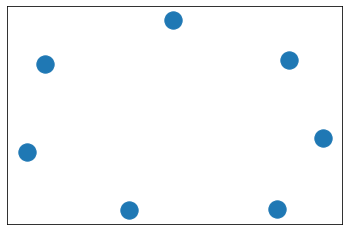

In [216]:
nx.draw_networkx_nodes(G,nx.spring_layout(G), with_labels=True)